In [1]:
########################################
# 1. Module Installation & Data Loading
# 1-1. Module Installation
########################################
import importlib.util
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Required Modules
MODULES = ['pandas', 'nltk', 'gensim', 'matplotlib', 'pyLDAvis']

# Install Modules (if any of them are not installed yet)
def install_modules(modules=MODULES):
    for module in modules:
        if module not in sys.modules and importlib.util.find_spec(module) is None:
            !{sys.executable} -m pip install -q {module} --upgrade

# Module Installation
install_modules()

In [2]:
########################################
# 1-2. Setup & Data Loading
########################################
import os
import pandas as pd
from datetime import datetime

# Seed for Reproducible Results
SEED = 2
os.environ["PYTHONHASHSEED"] = str(SEED)

DATA_PATH = 'Data' # Data Folder's Name
assert os.path.isdir(DATA_PATH)
ARTICLES_FILE = 'articles.csv' # Data Processed Dataset
MVPS_FILE = 'mvps.csv' # Supporting Dataset

# Configure Years & Months
MIN_MAX_MONTHS = {'min': 4, 'max': 10} # Range of Months for the Articles
MIN_MAX_YEARS = {'min': 2011, 'max': 2021} # Range of Years for the Articles
YEARS = [2018, 2019, 2020, 2021] # Range of Years to Evaluate

# Specify Columns & Data Types
USECOLS = ['id', 'headline', 'summary', 'created', 'source']
DTYPES = {'id': str, 'headline': str, 'summary': str, 'created': str, 'source': str}
COLUMNS = ['id', 'year', 'text']

# Specify Columns & Data Types for Supporting Dataset
USECOLS_SUP = ['id', 'name', 'team', 'league', 'year']
DTYPES_SUP = {'id': int, 'name': str, 'team': str, 'league': str, 'year': int}

# Load Dataframe
def load_dataframe(file_path, usecols, dtype):
    df = pd.read_csv(file_path, usecols=usecols, dtype=dtype)
    return df

# Concat Csvs
def concat_csvs():
    # Load Dataset in Data Folder (reuters.csv, mlb.csv, wsj.csv, nyt.csv, espn.csv)
    csvs = []
    for [r, d, f] in os.walk(DATA_PATH): # r=root directory path, d=directory names, f=file names
        for file in f:
            if file not in [ARTICLES_FILE, MVPS_FILE]:
                csv = load_dataframe(('%s/%s' % (DATA_PATH, file)), USECOLS, DTYPES)
                csvs.append(csv)
    articles = pd.concat(csvs)
    return articles

# Articles Dataset
articles = concat_csvs()

# MVPs (Supporting) Dataset
mvps = load_dataframe(('%s/%s' % (DATA_PATH, MVPS_FILE)), USECOLS_SUP, DTYPES_SUP)

In [3]:
########################################
# 2. Data Cleaning & Preprocessing
########################################
import calendar
import string
import re
import csv

# Filter Created
def filter_created(df1):
    dfs = []
    for year in range(MIN_MAX_YEARS['min'], MIN_MAX_YEARS['max']+1):
        if year == MIN_MAX_YEARS['max'] and end_month < start_month:
            break
        
        # Start Date
        start_month = MIN_MAX_MONTHS['min']
        start_month = ('0' if start_month < 10 else '') + str(start_month)
        start_date = pd.to_datetime(str(year) + start_month + '01')
        
        # End Date
        end_month = MIN_MAX_MONTHS['max']
        if end_month < MIN_MAX_MONTHS['min']:
            year += 1
        end_day = calendar.monthrange(year, end_month)[1] # number of days in the month
        end_day = ('0' if end_day < 10 else '') + str(end_day)
        end_month = ('0' if end_month < 10 else '') + str(end_month)
        end_date = pd.to_datetime(str(year) + end_month + end_day)
        
        df_ = df1[(pd.to_datetime(df1['created']) >= start_date) & (pd.to_datetime(df1['created']) <= end_date)]
        dfs.append(df_)
    df = pd.concat(dfs)
    return df

# Remove Duplicates
def remove_duplicates(df1):
    df = df1.drop_duplicates(subset=['headline', 'summary'])
    return df

# Preprocess Text
def preprocess_text(text):
    text = text.str.lower() # lowercase
    text = text.apply(lambda x: re.sub(r'\n', ' ', str(x))) # replace newline with space
    text = text.apply(lambda x: re.sub(r'\r', ' ', str(x))) # replace return with space
    
    # Replace punctuation (special characters) with a whitespace
    dictionary = dict.fromkeys(string.punctuation, ' ') # e.g. {'=' : ' '}
    trans_dictionary = str.maketrans(dictionary) # dictionary for translation 
    text = text.str.translate(trans_dictionary) # replace punctuation with a whitespace
    
    text = text.apply(lambda x: re.sub(r'\d+', ' ', str(x))) # replace digit with a whitespace
    text = text.apply(lambda x: re.sub(r'\ss\s', ' ', str(x))) # replace (whitespace)s(whitespace) with a whitespaceace
    text = text.apply(lambda x: re.sub(r'\s+', ' ', str(x))) # replace multiple whitespaces with a whitespace
    text = text.apply(lambda x: re.sub(r'\s(\w{1})\s(\w{1})\s',  r' \1\2 ', str(x))) # e.g. ' n y ' -> 'ny'
    text = text.apply(lambda x: re.sub(r'(^\w{1})\s(\w{1})\s',  r'\1\2 ', str(x))) # e.g. 'n y ' -> 'ny'
    text = text.apply(lambda x: re.sub(r'(\w+)\s([t]{1})\s',  r'\1\2 ', str(x))) # e.g. 'wasn t ' -> 'wasnt'
    text = text.str.strip() # strip the left and the right whitespace
    return text

# Concat Text (Headline and Summary)
def concat_text(df1):
    df1 = df1.sort_values(['created'], ascending=True)
    df = pd.DataFrame(columns=['id', 'year', 'text'])
    for row in df1.itertuples():
        df = df.append({'id': row.id,
                        'year': int(row.created[:4]),
                        'text': str(' '.join([str(row.headline), str(row.summary)]))}, ignore_index=True)
    return df

# Concat Name
def concat_name(df2):
    df2 = df2.sort_values(['year'], ascending=True)
    df = pd.DataFrame(columns=['year', 'name'])
    for y in range(MIN_MAX_YEARS['min'], MIN_MAX_YEARS['max']+1):
        rows = df2[df2['year'].astype(int)==y]
        df = df.append({'year': int(y), 'name': str(';'.join(rows['name'].str.lower()))}, ignore_index=True)
    return df

# Merge Articles (& MVPs as option)
def save_articles(df1, df2=None, file_name=ARTICLES_FILE):
    if mvps is None:
        df1 = pd.merge(df1, df2, how='left', on=['year'])
        COLUMNS.append('name')
    df = df1.sort_values(['id'], ascending=True)
    df.to_csv('%s/%s' % (DATA_PATH, file_name), columns=COLUMNS,
              index=False, header=True, quoting=csv.QUOTE_NONE, escapechar='')
    return df

# Preprocess Articles (& MVPs as option)
def preprocess_articles(df1, df2=None):
    df1 = filter_created(df1)
    df1 = remove_duplicates(df1)
    df1.headline = preprocess_text(df1.headline)
    df1.summary = preprocess_text(df1.summary)
    df1 = concat_text(df1)
    if df2 is not None:
        df2 = concat_name(df2)
    df = save_articles(df1, df2) # COLUMNS=['id', 'year', 'text', 'name']
    return df

# Preprocessed Article (& MVPs as option)
articles = preprocess_articles(articles, mvps)

# Stats: Number of Articles per Year
articles.groupby(['year']).size()

year
2011    160
2012     45
2013     67
2014     70
2015     80
2016     59
2017     94
2018    269
2019    429
2020    107
2021    942
dtype: int64

In [4]:
########################################
# 3. Document Processing
########################################
import nltk
nltk.download('wordnet') # for lemmatizer
import gensim
STOP_WORDS = ['mlb', 'major', 'league', 'baseball', 'game', 'team', 'player']
stop_words = gensim.parsing.preprocessing.STOPWORDS.union(set(STOP_WORDS))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Masami\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
########################################
# 3-1. Lemmatizer & Stemmer Test
# Find out which method to use
########################################
pd.set_option('display.max_columns', None) # None=auto detect

def test_lemmatizer_stemmer(text):
    # Stop Words Removal
    swr = [token for token in text if token not in stop_words]
    
    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized = ['Lemmatizer'] + [lemmatizer.lemmatize(token) for token in swr]
    
    # Snowball English Stemmer
    snowball = nltk.stem.snowball.EnglishStemmer()
    snowballed = ['Snowball'] + [snowball.stem(token) for token in swr]
    
    # Porter Stemmer
    porter = nltk.stem.porter.PorterStemmer()
    portered = ['Porter'] + [porter.stem(token) for token in swr]
    
    # Lancaster Stemmer
    lancaster = nltk.stem.lancaster.LancasterStemmer()
    lancastered = ['Lancaster'] + [lancaster.stem(token) for token in swr]
    
    df = pd.DataFrame([lemmatized, snowballed, portered, lancastered], columns=[''] + swr)
    return df

def print_text_note(text, note):
    print('Sample Text:\n', ' '.join(text), '\n' + note)

In [6]:
########################################
# 3-1-1. Lemmatizer & Stemmer Test1
# Find out Lemmatizer works fine
########################################
sample_text1 = articles.text.values[101].split()
note1 = "NOTE: Lemmatizer groups words, Porter transforms 'los' into 'lo' and Lancaster transforms 'dodgers' into 'dodg.'"
print_text_note(sample_text1, note1)
test_lemmatizer_stemmer(sample_text1)

Sample Text:
 judge blocks dodgers requests a bankruptcy judge blocked a request by the los angeles dodgers to gather testimony from baseball commissioner bud selig 
NOTE: Lemmatizer groups words, Porter transforms 'los' into 'lo' and Lancaster transforms 'dodgers' into 'dodg.'


,,judge,blocks,dodgers,requests,bankruptcy,judge,blocked,request,los,angeles,dodgers,gather,testimony,commissioner,bud,selig
0,Lemmatizer,judge,block,dodger,request,bankruptcy,judge,blocked,request,los,angeles,dodger,gather,testimony,commissioner,bud,selig
1,Snowball,judg,block,dodger,request,bankruptci,judg,block,request,los,angel,dodger,gather,testimoni,commission,bud,selig
2,Porter,judg,block,dodger,request,bankruptci,judg,block,request,lo,angel,dodger,gather,testimoni,commission,bud,selig
3,Lancaster,judg,block,dodg,request,bankruptcy,judg,block,request,los,angel,dodg,gath,testimony,commit,bud,selig


In [7]:
########################################
# 3-1-2. lemmatizer & Stemmer Test2
# Find out Snowball Stemmer works fine
########################################
sample_text2 = 'dodging dodgers bankruptcies testimonies committed commits commissioner commissioning laud laudly generous generically'.split()
note2 = "NOTE: Snowball treats 'laud' & 'laudly' same, 'generous' and 'generically' differently. Snowball seems the best."
print_text_note(sample_text2, note2)
test_lemmatizer_stemmer(sample_text2)

Sample Text:
 dodging dodgers bankruptcies testimonies committed commits commissioner commissioning laud laudly generous generically 
NOTE: Snowball treats 'laud' & 'laudly' same, 'generous' and 'generically' differently. Snowball seems the best.


,,dodging,dodgers,bankruptcies,testimonies,committed,commits,commissioner,commissioning,laud,laudly,generous,generically
0,Lemmatizer,dodging,dodger,bankruptcy,testimony,committed,commits,commissioner,commissioning,laud,laudly,generous,generically
1,Snowball,dodg,dodger,bankruptci,testimoni,commit,commit,commission,commiss,laud,laud,generous,generic
2,Porter,dodg,dodger,bankruptci,testimoni,commit,commit,commission,commiss,laud,laudli,gener,gener
3,Lancaster,dodg,dodg,bankruptcy,testimony,commit,commit,commit,commit,laud,laud,gen,gen


In [8]:
########################################
# 3-2. Vocabulary
########################################
# Minimum total count in the collection
MIN_COUNT = 1 

# Phrase of words `a` and `b`: (cnt(a, b) - min_count) * TotalVocabSize / (cnt(a) * cnt(b)) > threshold
THRESHOLD = 1 # smaller: longer phrases (e.g. Los Angeles Angeles)
    
# Create Vocabulary
def create_vocabulary(docs):
    # Tokenize Word
    docs_tokenized = [doc.split() for doc in docs]
    
    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    docs_lemmatized = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs_tokenized]
    
    # Remove Stop Words
    docs_sw_removed = [[token for token in doc if token not in stop_words] for doc in docs_lemmatized]

    # Snowball English Stemming
    stemmer = nltk.stem.snowball.EnglishStemmer()
    docs_stemmed = [[stemmer.stem(token) for token in doc] for doc in docs_sw_removed]
    return docs_stemmed

In [9]:
########################################
# 3-3. MIN_COUNT Test
# Find out the value for MIN_COUNT
########################################
def print_vocab_note(docs, note):
    vocab = create_vocabulary(docs)
    print('Sample Processed Documents:\n', vocab, '\n' + note)
    #print(vocab)
    #print('\n' + note)
    return vocab

def test_min_count(docs, min_count):
    print('\n' + 'MIN_COUNT = ' + str(min_count))
    bigram = gensim.models.Phrases(docs, min_count=min_count, threshold=1).freeze()
    for doc in docs:
        print(bigram[doc])

sample_docs = ["He plays baseball in Los Angeles today", "He is playing in Los Angeles today", "He played with Angeles today"]
note = "NOTE: There are 3 'angel today' and 2 'los angel'. It is hard to configure MIN_COUNT. MIN_COUNT = 1 seems the best due to 'los_angel'."
sample_vocab = print_vocab_note(sample_docs, note)

test_min_count(sample_vocab, 1) # MIN_COUNT = 1
test_min_count(sample_vocab, 2) # MIN_COUNT = 2

Sample Processed Documents:
 [['he', 'play', 'los', 'angel', 'today'], ['he', 'play', 'los', 'angel', 'today'], ['he', 'play', 'angel', 'today']] 
NOTE: There are 3 'angel today' and 2 'los angel'. It is hard to configure MIN_COUNT. MIN_COUNT = 1 seems the best due to 'los_angel'.

MIN_COUNT = 1
['he_play', 'los_angel', 'today']
['he_play', 'los_angel', 'today']
['he_play', 'angel_today']

MIN_COUNT = 2
['he_play', 'los', 'angel_today']
['he_play', 'los', 'angel_today']
['he_play', 'angel_today']


In [10]:
########################################
# 3-4. N-gram Model & Terms
########################################
# Create N-gram Model
def create_ngram_model(docs):
    ngram_model = gensim.models.Phrases(docs, min_count=MIN_COUNT, threshold=THRESHOLD).freeze()
    return ngram_model

# Create Trigram Terms
def create_trigram_terms(docs):
    # Vocabulary
    vocab = create_vocabulary(docs)
    
    bigram_model = create_ngram_model(vocab)
    bigram_terms = [bigram_model[doc] for doc in vocab]
    trigram_model = create_ngram_model(bigram_model[vocab])
    trigram_terms = [trigram_model[terms] for terms in bigram_terms]
    return trigram_terms

########################################
# 3-5. Dictionary & Corpus
########################################
# Create Dictionary: {TermID: Term} (e.g. {0: 'apple', 1: 'banana'})
def create_dictionary(docs):
    # Trigram Terms
    trigram_terms = create_trigram_terms(docs)

    # Dictionary
    dictionary = gensim.corpora.Dictionary(trigram_terms)
    return dictionary

# Create Dictionary for LDA Models
DICTIONARY = create_dictionary(articles.text.values)

# Create Corpus: [(TermID, Frequency)] (e.g. [(0, 1), (1, 2), ...])
def create_corpus(trigram_terms, dictionary=DICTIONARY):
    corpus = [dictionary.doc2bow(doc) for doc in trigram_terms]
    return corpus

# Create Trigram Terms & Corpus
def create_trigram_corpus(docs):    
    # Trigram Terms
    trigram_terms = create_trigram_terms(docs)
    
    # Corpus
    corpus = create_corpus(trigram_terms)
    return trigram_terms, corpus

In [11]:
###################################
# 4. Topic Model & Coherence Score
###################################
# LDA Model
NUMS_TOPICS = {'min': 2, 'max': 10} # Range of the Numbers of Topics for a Topic Model 
NUM_TOPICS = 5 # Default Number of Topics in the Corpus
CHUNKSIZE = 100 # Number of Documents in each Chunk
PASSES = 10 # Number of Passes in the Corpus
RANDOM_STATE = SEED # Seed for Reproducibility

# Build LDA Model
def build_lda_model(corpus, dictionary=DICTIONARY, num_topics=NUM_TOPICS, chunksize=CHUNKSIZE, passes=PASSES, random_state=RANDOM_STATE):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        chunksize=chunksize,
        passes=passes,
        random_state=random_state)
    return lda_model

# Coherence (c_v: using normalized pointwise mutual information (NPMI) and the cosine similarity)
COHERENCE = 'c_v'

# Compute Coherence Score
def compute_coherence_score(lda_model, trigram_terms, dictionary=DICTIONARY, coherence=COHERENCE):
    coherence_model = gensim.models.CoherenceModel(model=lda_model, texts=trigram_terms, dictionary=dictionary, coherence=COHERENCE)
    coherence_score = coherence_model.get_coherence()
    return coherence_score

# Optimize Number of Topics
def optimize_num_topics(trigram_terms, corpus, dictionary=DICTIONARY):
    lda_models = []
    coherence_scores = []
    for num_topics in range(NUMS_TOPICS['min'], NUMS_TOPICS['max']+1):
        lda_model = build_lda_model(corpus, dictionary, num_topics)
        lda_models.append(lda_model)
        coherence_score = compute_coherence_score(lda_model, trigram_terms, dictionary)
        coherence_scores.append(coherence_score)
    return lda_models, coherence_scores

In [12]:
###################################
# 5. Topic Model Evaluation
###################################
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))

# Save LDA Model for the year
def save_model(year):
    MODEL_PATH = 'Model' # Model Folder's Name
    os.makedirs(MODEL_PATH, exist_ok=True) # Make Model Folder, if it doesn't exist
    assert os.path.isdir(MODEL_PATH)
    MODEL_FILE = 'topic_model_' + str(year) + '.pkl'
    lda_model.save('%s/%s' % (MODEL_PATH, MODEL_FILE)) # to load: gensim.models.Phrases.load('%s/%s' % (MODEL_PATH, MODEL_FILE))

def get_mvps(year):
    vocab = []
    mvps_year = mvps[mvps['year']==year].iloc[:, [1,2,3,4]]
    names = mvps_year['name'].str.lower()
    for name in names:
        vocab.append(create_vocabulary([name])[0])
    return mvps_year, vocab

def print_mvps_topics(lda_model, names):
    # the most contributing terms for the optimal number of topics
    topics = lda_model.print_topics(num_words=300) # default=30
    
    for name in names:
        full_name = '_'.join(name)
        last_name = name[1]
        
        for topic in topics:
            text = topic[1]
            index_start = text.find(full_name) # find name by 2-gram (e.g. john_smith)
            if index_start < 0:
                index_start = text.find(last_name) # find name by last_name (e.g. smith)
            if index_start > -1:
                index_end = index_start + len(full_name) + 1
                text_before = text[:index_start]
                rank = text_before.count('+') + 1
                
                # the Top 5 Terms (abbreviate the rest of the terms)
                i = 0
                idx = text_before.find('+')
                while idx > -1 and i < 4:
                    idx = text_before.find('+', idx + 1)
                    i += 1
                
                display(Markdown(f'**{name}**: {text_before[:idx]} ... **<font color=red>{text[index_start:index_end]}</font>** (**{rank}** th) ...'))
    
def evaluate_model(year, to_save=False):
    # Documents for the year
    docs = articles[articles['year']==year]['text']

    trigram_terms, corpus = create_trigram_corpus(docs)
    lda_models, coherence_scores = optimize_num_topics(trigram_terms, corpus)
    
    num_topics_index = coherence_scores.index(max(coherence_scores))
    x = range(NUMS_TOPICS['min'], NUMS_TOPICS['max']+1)
    
    # Number of Topics Graph
    plt.plot(x, coherence_scores)
    plt.xticks([i for i in range(min(x), max(x)+1)])
    plt.title("Number of Topics v.s. Coherence Score")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.legend(("coherence_scores"), loc='best')
    plt.show()

    # Optimal LDA Model
    lda_model = lda_models[num_topics_index]
    if to_save:
        save_model(year)

    num_topics = x[num_topics_index]
    print('Optimal Number of Topics: ' + str(num_topics))
    print('Best Coherence Score: ' + str(coherence_scores[num_topics_index]))
    print('MVPs in any of the ' + str(num_topics) + ' Topics:')
    
    # MVPs for the year
    mvps_year, names = get_mvps(year)
    print(mvps_year)
    print('\n')
    
    # Print MVPs mentioned in any Topic
    print_mvps_topics(lda_model, names)
    
    return lda_model, corpus

In [13]:
###################################
# 6. Topic Model Visualization
###################################
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

# Remove Scrollbars and boxes
display(HTML("<style>" +
             "div.output_scroll { height: 100% !important; box-shadow: none; }" +
             "div.output_subarea { overflow-x: hidden !important; }" +
             ".jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { overflow-y: hidden !important; max-height: 100%; box-shadow: none; }</style>"))

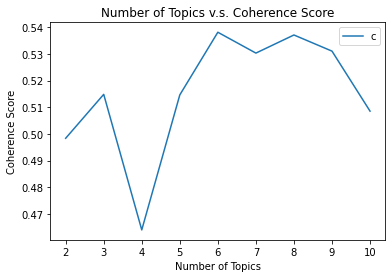

Optimal Number of Topics: 6
Best Coherence Score: 0.5381005525076664
MVPs in any of the 6 Topics:
                name               team    league  year
14      Mookie Betts     Boston Red Sox  American  2018
15  Christian Yelich  Milwaukee Brewers  National  2018




**['mooki', 'bett']**: 0.010*"red_sox" + 0.006*"pitcher" + 0.006*"ray" + 0.005*"angel" + 0.005*"ha"  ... **<font color=red>mooki_bett"</font>** (**74** th) ...

**['christian', 'yelich']**: 0.008*"best" + 0.003*"sixth_inning" + 0.003*"playoff" + 0.003*"brewer" + 0.003*"houston_astro"  ... **<font color=red>christian_yelich"</font>** (**11** th) ...

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.124952 -0.004204       1        1  29.340592
0      0.024501  0.064114       2        1  19.229467
3      0.031700 -0.083091       3        1  18.941896
4      0.026164  0.008462       4        1  13.206285
2      0.021534  0.013650       5        1  11.360311
1      0.021051  0.001069       6        1   7.921449, topic_info=                Term       Freq      Total Category  logprob  loglift
2             dodger   8.000000   8.000000  Default  30.0000  30.0000
569        los_angel   9.000000   9.000000  Default  29.0000  29.0000
856          red_sox  13.000000  13.000000  Default  28.0000  28.0000
1237            best   4.000000   4.000000  Default  27.0000  27.0000
379          pitcher   7.000000   7.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
1876  oakland_athlet   0.449783   1.131207   Topic6  -6.6209   1.6133
113             left   0.525497   1.719661   Topic6  -6.4653   1.3501
3637  cincinnati_red   0.430049   1.572274   Topic6  -6.6658   1.2392
243            astro   0.499807   3.919867   Topic6  -6.5154   0.4760
354             year   0.473591   3.245441   Topic6  -6.5693   0.6109

[317 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4080      5  1.143841      aaron
2449      1  0.954779         ad
3074      4  0.975263   advantag
3595      5  1.144336  alex_cora
4068      4  0.894705   anderson
...     ...       ...        ...
255       3  0.712613      worst
119       1  0.710250      yanke
119       3  0.177563      yanke
354       3  0.616249       year
4982      5  0.871568       your

[324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 4, 5, 3, 2])

In [14]:
###################################
# 6-1. Topic Model Year 2018
###################################
lda_model_2018, corpus_2018 = evaluate_model(YEARS[0]) # 2018
pyLDAvis.gensim_models.prepare(lda_model_2018, corpus_2018, dictionary=DICTIONARY)

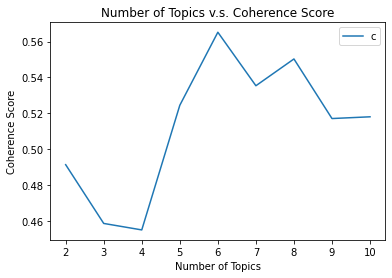

Optimal Number of Topics: 6
Best Coherence Score: 0.5651823098122875
MVPs in any of the 6 Topics:
              name                 team    league  year
16      Mike Trout   Los Angeles Angels  American  2019
17  Cody Bellinger  Los Angeles Dodgers  National  2019




**['mike', 'trout']**: 0.009*"angel" + 0.007*"late" + 0.006*"won" + 0.005*"doubl" + 0.005*"employe"  ... **<font color=red>mike_trout"</font>** (**46** th) ...

**['codi', 'belling']**: 0.014*"nation" + 0.012*"astro" + 0.010*"win" + 0.009*"washington" + 0.009*"houston_astro"  ... **<font color=red>codi_belling"</font>** (**273** th) ...

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.159815  0.031385       1        1  24.467356
5      0.048228 -0.054287       2        1  20.408910
3      0.012527 -0.072591       3        1  17.763306
2      0.077215  0.113821       4        1  14.549842
0      0.014592 -0.015318       5        1  11.764076
1      0.007252 -0.003010       6        1  11.046511, topic_info=                   Term       Freq      Total Category  logprob  loglift
1175         world_seri  28.000000  28.000000  Default  30.0000  30.0000
251              nation  21.000000  21.000000  Default  29.0000  29.0000
1669  washington_nation  11.000000  11.000000  Default  28.0000  28.0000
243               astro  22.000000  22.000000  Default  27.0000  27.0000
1051         washington  14.000000  14.000000  Default  26.0000  26.0000
...                 ...        ...        ...      ...      ...      ...
2627       max_scherzer   1.639081   3.703427   Topic6  -6.0147   1.3879
2174               padr   1.653499   4.277840   Topic6  -6.0060   1.2525
121              inning   1.735638   6.909827   Topic6  -5.9575   0.8215
1324               nlcs   1.638717   4.284205   Topic6  -6.0150   1.2420
5431               abus   1.638241   4.310530   Topic6  -6.0153   1.2356

[283 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5431      3  0.463980         abus
5431      6  0.463980         abus
15        4  0.807645        accus
669       4  0.770691          ace
1789      2  0.940985       actual
...     ...       ...          ...
354       1  0.265279         year
354       2  0.530558         year
354       4  0.265279         year
5724      1  0.931761   york_yanke
1779      5  0.745598  zack_greink

[299 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 4, 3, 1, 2])

In [15]:
###################################
# 6-2. Topic Model Year 2019
###################################
lda_model_2019, corpus_2019 = evaluate_model(YEARS[1]) # 2019
pyLDAvis.gensim_models.prepare(lda_model_2019, corpus_2019, dictionary=DICTIONARY)

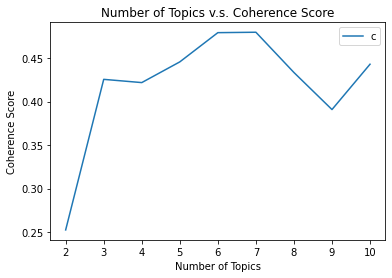

Optimal Number of Topics: 7
Best Coherence Score: 0.47952616194300196
MVPs in any of the 7 Topics:
               name               team    league  year
18       Jose Abreu  Chicago White Sox  American  2020
19  Freddie Freeman     Atlanta Braves  National  2020




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.084842  0.007002       1        1  24.692763
0      0.027788 -0.038007       2        1  17.206602
6      0.011082 -0.008149       3        1  14.392502
5      0.030924  0.059518       4        1  12.952968
4      0.005747 -0.007266       5        1  12.418027
2      0.003933 -0.008394       6        1  10.329385
1      0.005369 -0.004704       7        1   8.007753, topic_info=               Term       Freq      Total Category  logprob  loglift
1175     world_seri   5.000000   5.000000  Default  30.0000  30.0000
2            dodger  11.000000  11.000000  Default  29.0000  29.0000
569       los_angel   4.000000   4.000000  Default  28.0000  28.0000
2276          video   2.000000   2.000000  Default  27.0000  27.0000
6915  brett_phillip   3.000000   3.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
13               wa   0.054704   0.247227   Topic7  -7.7755   1.0164
1089        multipl   0.054704   0.247227   Topic7  -7.7755   1.0164
747           treat   0.054704   0.249890   Topic7  -7.7755   1.0057
286           money   0.054704   0.311445   Topic7  -7.7756   0.7855
6707    hang_balanc   0.054704   0.240897   Topic7  -7.7756   1.0423

[317 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
162       1  0.945640      answer
2063      4  0.774937       apiec
2011      4  0.743308        beat
1237      4  0.659150        best
494       4  0.743275      better
...     ...       ...         ...
1526      1  0.945640         wit
523       4  0.774920         won
1175      2  0.356859  world_seri
1175      4  0.713718  world_seri
354       2  1.063702        year

[107 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 6, 5, 3, 2])

In [16]:
###################################
# 6-3. Topic Model Year 2020
###################################
lda_model_2020, corpus_2020 = evaluate_model(YEARS[2]) # 2020
pyLDAvis.gensim_models.prepare(lda_model_2020, corpus_2020, dictionary=DICTIONARY)

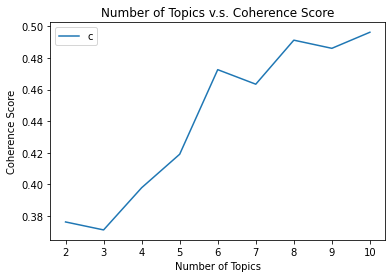

Optimal Number of Topics: 10
Best Coherence Score: 0.49633703364740034
MVPs in any of the 10 Topics:
             name                  team    league  year
20  Shohei Ohtani    Los Angeles Angels  American  2021
21   Bryce Harper  Washington Nationals  National  2021




**['shohei', 'ohtani']**: 0.015*"seri" + 0.013*"new" + 0.010*"octob" + 0.010*"singl" + 0.009*"angel"  ... **<font color=red>shohei_ohtani"</font>** (**10** th) ...

**['bryce', 'harper']**: 0.025*"manag" + 0.011*"end" + 0.010*"histori" + 0.010*"moment" + 0.009*"walk"  ... **<font color=red>bryce_harper"</font>** (**122** th) ...

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.326542 -0.019448       1        1  21.271278
0     -0.035311 -0.189141       2        1  15.265450
1      0.007347  0.192608       3        1  12.615460
9     -0.041544  0.036712       4        1  10.813167
5     -0.057471  0.030778       5        1  10.234035
8     -0.051020 -0.046502       6        1   8.478140
2     -0.017935 -0.027697       7        1   7.460514
4     -0.055776  0.024548       8        1   5.700529
7     -0.045583  0.000223       9        1   5.287680
6     -0.029249 -0.002081      10        1   2.873747, topic_info=                     Term       Freq      Total Category  logprob  loglift
2                  dodger  46.000000  46.000000  Default  30.0000  30.0000
569             los_angel  50.000000  50.000000  Default  29.0000  29.0000
3274        houston_astro  35.000000  35.000000  Default  28.0000  28.0000
1260              playoff  69.000000  69.000000  Default  27.0000  27.0000
141                 manag  39.000000  39.000000  Default  26.0000  26.0000
...                   ...        ...        ...      ...      ...      ...
8447  giant_san_francisco   0.872097   1.400256  Topic10  -6.1526   3.0760
4912              nl_west   0.842439   1.370577  Topic10  -6.1872   3.0629
7386           logan_webb   0.838295   1.366465  Topic10  -6.1921   3.0609
4384          kris_bryant   0.833767   1.361831  Topic10  -6.1975   3.0589
2249                  cub   2.048920   4.266917  Topic10  -5.2984   2.8160

[401 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4939      2  0.918828      aaron_boon
3414      8  0.842294          action
2449      3  0.896223              ad
1424      6  0.863280             add
1155      1  0.990021          advanc
...     ...       ...             ...
119       2  0.467681           yanke
119       6  0.049230           yanke
354       1  0.986770            year
34        7  0.959630        year_old
9109      3  0.959804  yordan_alvarez

[424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 10, 6, 9, 3, 5, 8, 7])

In [17]:
###################################
# 6-4. Topic Model Year 2021
###################################
lda_model_2021, corpus_2021 = evaluate_model(YEARS[3]) # 2021
pyLDAvis.gensim_models.prepare(lda_model_2021, corpus_2021, dictionary=DICTIONARY)

In [18]:
###################################
# 7. LDA Model Diagram
###################################
# CSS for LDA Diagram
display(HTML("<style>" +
             ".diagram_div { text-align: center; font-size: 24px; }" +
             ".grand_div, .parent_div, .child_title_div, .child_doc_div, .child_text_div, .child_sentence_div, .child_box_div { padding: 10px; }" +
             ".grand_grand_box_div, .child_box_div { border-style: solid; border-width:thin; border-color: #00000; }" +
             ".grand_box_div { border-left: solid; border-right: solid; border-width:thin; border-color: #00000; }" +
             ".grand_grand_div, .grand_grand_box_div { display: flex; }" +
             ".grand_div, .grand_box_div { flex: 1; margin: auto; text-align: left; }" +
             ".parent_title_div { text-align: center; font-size: 16px; }" +
             ".parent_doc_div { width: 800px; background-color: #EAECEE; font-size: 16px; }" +
             ".parent_div { display: flex; width: 800px; }" +
             ".child_text_div, .child_sentence_div { float:left; margin: auto; text-align: center; }" +
             ".child_text_div { width: 100px; }" +
             ".child_sentence_div { width: 300px; }" +
             ".child_box_div { float: left; width: 200px; }</style>"))

TOPIC_COLORS = ['Crimson', 'HotPink', 'DarkOrange', 'LightSeaGreen', 'DodgerBlue', 'BlueViolet', 'Orchid', 'SeaGreen', 'MediumBlue', 'MediumSlateBlue']

# Get Topic Distribution in a Document
def get_topic_distribution(lda_model, bow):
    topic_ids_colors = {}
    text_doc_topics = []
    doc_topics = lda_model.get_document_topics(bow, minimum_probability=1e-2) # 1e-2 = 10^-2 = 0.01
    doc_topics.sort(key=lambda x:x[1], reverse=True)
    for i, (topic_id, prob) in enumerate(doc_topics):
        topic_ids_colors[topic_id] = TOPIC_COLORS[i]
    return topic_ids_colors, doc_topics

# Create Term with most likely Topic Map
def create_term_topic_map(lda_model, bow):
    terms_topic = {}
    for word_id, freq in bow:
        term_topics = lda_model.get_term_topics(word_id, minimum_probability=1e-5) # 1e-5 = 10^-5 = 0.00001
        if term_topics:
            term_topics.sort(key=lambda x:x[1], reverse=True)
            terms_topic[DICTIONARY[word_id]] = term_topics[0] # terms_topic[term] = (topic_id, prob) <- the top tuple has the highest prob
    return terms_topic

# Display Term with most likely Topic
def display_terms_topic(doc, terms_topic, topic_ids_colors, doc_topics):
    text_terms_topic = []
    text_topic_terms_probs = {}
    for word in doc.split():
        word_color = word
        vocab = create_vocabulary([word])[0]; # [['shohei']] -> ['shohei']
        if vocab and vocab[0] in terms_topic: # ['shohei'] -> 'shohei'
            term = vocab[0]
            if term in terms_topic:
                topic_id = terms_topic[term][0]
                prob = terms_topic[term][1]
                if topic_id in topic_ids_colors:
                    color = topic_ids_colors[topic_id]
                    word_color = '<font color=' + color + '><b>' + word + '</b></font>'
                    word_prob = '<font color=' + color + '><b>' + word + '</b> (' + str(round(prob, 5)) + ')</font><br>'
                    text_topic_terms_probs[topic_id] = text_topic_terms_probs.get(topic_id, '') + word_prob
        text_terms_topic.append(word_color)
    
    # Title Section
    title1 = "<b>m</b> Words Probability Distribution<br>(from Dirichlet Dist.)<br>on <b>i</b>-th Topic θi"
    title2 = "<u>Document</u>: " + " ".join(text_terms_topic)
    title3 = "<b>k</b> Topics Probability Distribution<br>(from Dirichlet Dist.)<br>on <b>d</b>-th Document πd"
    titles = "<div class='grand_grand_div'>"
    titles += "<div class='grand_div'><div class='parent_title_div'>" + title1 + "</div></div>"
    titles += "<div class='grand_div'><div class='parent_doc_div'>" + title2 + "</div></div>"
    titles += "<div class='grand_div'><div class='parent_title_div'>" + title3 + "</div></div></div>"

    # Diagram Section
    html = ''
    for i, (topic_id, prob) in enumerate(doc_topics):
        words_probs = text_topic_terms_probs[topic_id]
        color = topic_ids_colors[topic_id]
        id = "<font color='" + color + "'><b>" + str(topic_id) + "</b></font>"
        words = "p(w1|θ" + id + ")<br>p(w2|θ" + id + ")<br>...<br>p(wm|θ" + id + ")"
        topic = "← Topic θ" + id
        formula = "← p(θ" + id + ") = p(πd," + id + ") = <u>Topic " + id + ": " + str(prob) + "</u> ←"
        html += "<div class='parent_div'><div class='child_text_div'>" + words + "</div><div class='child_text_div'>" + topic + "</div><div class='child_box_div'>" + words_probs + "</div><div class='child_sentence_div'>" + formula + "</div></div>" # color = topic_ids_colors[topic_id]

    nbsps = "&nbsp;&nbsp;&nbsp;&nbsp;"
    div1 = nbsps + "→<br>p(θ<b>i</b>)<br>= (p(w1|θi),<br>" + nbsps + "p(w2|θi)),<br>" + nbsps + "...<br>" + nbsps + "p(w<b>m</b>|θi))<br><br><br>"
    div1 += "= (Dirichlet(β1),<br>" + nbsps + "Dirichlet(β2),<br>" + nbsps + "...,<br>" + nbsps + "Dirichlet(β<b>m</b>))<br>"
    div2 = nbsps + "→<br>p(π<b>d</b>)<br>= (p(πd,1),<br>" + nbsps + "p(πd,2),<br>" + nbsps + "...<br>" + nbsps + "p(πd,<b>k</b>))<br><br><br>"
    div2 += "= (Dirichlet(α1),<br>" + nbsps + "Dirichlet(α2),<br>" + nbsps + "...,<br>" + nbsps + "Dirichlet(α<b>k</b>))<br>"
    divs = "<div class='grand_grand_box_div'>"
    divs += "<div class='grand_div'>" + div1 + "</div>"
    divs += "<div class='grand_box_div'>" + html + "</div>"
    divs += "<div class='grand_div'>" + div2 + "</div></div>"
    display(HTML(titles + divs))
    display(Markdown(f'------------------------------------------------------------------------------------------------------------------------'))

# Display Diagram
def display_diagram(lda_model, docs):
    trigram_terms_2021, corpus_2021 = create_trigram_corpus(docs)
    for i, bow in enumerate(corpus_2021):
        
        # Get Topic Distribution in a Document
        topic_ids_colors, doc_topics = get_topic_distribution(lda_model, bow)
        
        # Create Term with most likely Topic Map
        terms_topic = create_term_topic_map(lda_model, bow)
        
        # Display Term with most likely Topic
        display_terms_topic(docs[i], terms_topic, topic_ids_colors, doc_topics)

# LDA Model Diagram
display(HTML("<div class='diagram_div'><u>LDA Model Diagram: m Words per Topic & k Topics per Document - 2 samples</u></div>"))
docs_2021 = [articles[articles['id']=="20210514403"].text.values[0], articles[articles['id']=="20210517104"].text.values[0]] # ['shohei ohtani ...', '']
display_diagram(lda_model_2021, docs_2021)

------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------